# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import numpy as np
import random
import time
import torch
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name="Reacher_Windows_x86_64/Reacher.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.3499999921768904


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from ddpg_agent import Agent

In [6]:
# DDPG

def ddpg(n_episodes=1000, max_t=1000, print_every=1):
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes  (int)   : maximum number of training episodes
        max_t       (int)   : maximum number of timesteps per episode
        print_every (int)   : interval to display results

    """
    mean_scores = []                               # list of mean scores from each episode
    means_moving = []                              # list of means of moving

    scores_window = deque(maxlen=100)              # mean scores from most recent 100 episodes
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       # reset environment
        states = env_info.vector_observations                   # get the current state (for each agent)      
        scores = np.zeros(num_agents)                           # initialize the score (for each agent)
        
        agent.reset()
        
        start = time.time()
        
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action (for each agent)
            env_info = env.step(actions)[brain_name]            # send all actions to tne environment
            next_states = env_info.vector_observations          # get next state (for each agent)
            rewards = env_info.rewards                          # get reward (for each agent)
            dones = env_info.local_done                         # see if episode finished
            
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states                                # roll over states to next time step
            scores += rewards                                   # update the score (for each agent)
            if np.any(dones):                                   # exit loop if episode finished
                break
                
        end = time.time()
        duration = end - start
        
        mean_scores.append(np.mean(scores))           # save mean score for the episode
        scores_window.append(mean_scores[-1])         # save mean score to window
        means_moving.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} ({}s)\tMean: {:.1f}\tMoving Avg: {:.1f}'.format(\
                  i_episode, round(duration), mean_scores[-1], means_moving[-1]))
                  
        if means_moving[-1] >= 31.00 and i_episode >= 100:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, means_moving[-1]))            
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return mean_scores, means_moving

In [7]:
# training loop
start = time.time()
agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=4)
mean_scores, means_moving = ddpg()
end = time.time()

Episode 1 (21s)	Mean: 0.4	Moving Avg: 0.4
Episode 2 (22s)	Mean: 1.3	Moving Avg: 0.9
Episode 3 (22s)	Mean: 1.7	Moving Avg: 1.1
Episode 4 (22s)	Mean: 1.1	Moving Avg: 1.1
Episode 5 (21s)	Mean: 0.6	Moving Avg: 1.0
Episode 6 (21s)	Mean: 0.3	Moving Avg: 0.9
Episode 7 (20s)	Mean: 1.2	Moving Avg: 0.9
Episode 8 (20s)	Mean: 1.4	Moving Avg: 1.0
Episode 9 (21s)	Mean: 0.9	Moving Avg: 1.0
Episode 10 (21s)	Mean: 1.4	Moving Avg: 1.0
Episode 11 (21s)	Mean: 1.6	Moving Avg: 1.1
Episode 12 (21s)	Mean: 3.3	Moving Avg: 1.3
Episode 13 (21s)	Mean: 2.1	Moving Avg: 1.3
Episode 14 (21s)	Mean: 1.2	Moving Avg: 1.3
Episode 15 (21s)	Mean: 2.1	Moving Avg: 1.4
Episode 16 (21s)	Mean: 1.5	Moving Avg: 1.4
Episode 17 (21s)	Mean: 1.6	Moving Avg: 1.4
Episode 18 (21s)	Mean: 0.7	Moving Avg: 1.4
Episode 19 (21s)	Mean: 1.1	Moving Avg: 1.3
Episode 20 (21s)	Mean: 4.2	Moving Avg: 1.5
Episode 21 (21s)	Mean: 1.5	Moving Avg: 1.5
Episode 22 (21s)	Mean: 2.8	Moving Avg: 1.5
Episode 23 (21s)	Mean: 5.8	Moving Avg: 1.7
Episode 24 (21s)	Mea

Episode 188 (22s)	Mean: 17.4	Moving Avg: 12.5
Episode 189 (22s)	Mean: 21.0	Moving Avg: 12.6
Episode 190 (21s)	Mean: 16.7	Moving Avg: 12.6
Episode 191 (22s)	Mean: 17.0	Moving Avg: 12.8
Episode 192 (22s)	Mean: 25.5	Moving Avg: 13.0
Episode 193 (22s)	Mean: 22.1	Moving Avg: 13.1
Episode 194 (22s)	Mean: 16.1	Moving Avg: 13.2
Episode 195 (21s)	Mean: 16.4	Moving Avg: 13.3
Episode 196 (21s)	Mean: 12.0	Moving Avg: 13.4
Episode 197 (21s)	Mean: 18.3	Moving Avg: 13.5
Episode 198 (22s)	Mean: 11.0	Moving Avg: 13.5
Episode 199 (22s)	Mean: 11.1	Moving Avg: 13.5
Episode 200 (21s)	Mean: 17.1	Moving Avg: 13.6
Episode 201 (21s)	Mean: 18.0	Moving Avg: 13.7
Episode 202 (22s)	Mean: 18.3	Moving Avg: 13.8
Episode 203 (22s)	Mean: 16.3	Moving Avg: 13.9
Episode 204 (22s)	Mean: 23.0	Moving Avg: 14.0
Episode 205 (22s)	Mean: 17.3	Moving Avg: 14.1
Episode 206 (23s)	Mean: 22.8	Moving Avg: 14.2
Episode 207 (22s)	Mean: 17.4	Moving Avg: 14.3
Episode 208 (21s)	Mean: 13.0	Moving Avg: 14.4
Episode 209 (22s)	Mean: 15.9	Movin

In [8]:
elapsed = (end - start) / 60.0 # in minutes
print("\nElapsed Time: {0:3.2f} mins.".format(elapsed))


Elapsed Time: 120.96 mins.


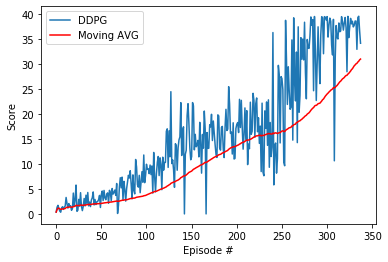

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(mean_scores)), mean_scores, label='DDPG')
plt.plot(np.arange(len(mean_scores)), means_moving, c='r', label='Moving AVG')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');

plt.savefig('./images/training.png')
plt.show()

In [39]:
# Test
from model import Actor

array_scores = []

agent = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

agent.actor_local = Actor(state_size, action_size, random_seed).to(device)
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))

for i in range(1, 11):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = agent.act(states, add_noise=False) 
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        
        if np.any(dones):                                  # exit loop if episode finished
            break
            
    array_scores.append(scores)  
    
    print('\rTest -> Episode {} : Score :{:.1f}'.format(i , np.mean(scores)))

Test -> Episode 1 : Score :38.2
Test -> Episode 2 : Score :33.8
Test -> Episode 3 : Score :35.0
Test -> Episode 4 : Score :34.9
Test -> Episode 5 : Score :29.8
Test -> Episode 6 : Score :36.9
Test -> Episode 7 : Score :31.9
Test -> Episode 8 : Score :39.5
Test -> Episode 9 : Score :29.0
Test -> Episode 10 : Score :39.5


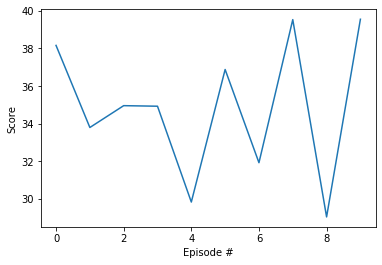

In [40]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(array_scores)), array_scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('./images/testing_score.png')

plt.show()

In [42]:
round(np.mean(array_scores))

35.0

When finished, you can close the environment.

In [43]:
env.close()